Goal: 
      
      - Design a framework to address the business Problem

      - Converting Business Problem into Data Problem
      
      - Derive Interesting Insights from the data
      
      - Build and Tune Machine Learning Models
      
      - Share results with correct stakeholders
      

**Problem Statement:** 
Prevent overstocking and understocking of Items by forecasting demand of items for the next week, based on historical data.

**Data Description:**

Train Data- 
- **WEEK_END_DATE** - week ending date
- **STORE_NUM** - store number
- **UPC** - (Universal Product Code) product specific identifier
- **BASE_PRICE** - base price of item
- **DISPLAY** - product was a part of in-store promotional display
- **FEATURE** - product was in in-store circular
- **UNITS** - units sold (target)

Product Data-
- **UPC** - (Universal Product Code) product specific identifier
- **DESCRIPTION**	- product description
- **MANUFACTURER** - product	manufacturer
- **CATEGORY** - category of product
- **SUB_CATEGORY** - sub-category of product
- **PRODUCT_SIZE** - package size or quantity of product

Store Data-
- **STORE_ID** - store number
- **STORE_NAME** - Name of store
- **ADDRESS_CITY_NAME** - city
- **ADDRESS_STATE_PROV_CODE** - state
- **MSA_CODE** - (Metropolitan Statistical Area) Based on geographic region and population density
- **SEG_VALUE_NAME** - Store Segment Name
- **PARKING_SPACE_QTY** - number of parking spaces in the store parking lot
- **SALES_AREA_SIZE_NUM** - square footage of store
- **AVG_WEEKLY_BASKETS** - average weekly baskets sold in the store

In [1]:
# import libraries
import seaborn as sns
import pandas as pd
import numpy as np
import random

sns.set_context('notebook', font_scale=1.5)

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


We have multiple datasets available for the project
- Weekly Sales Data:  Contains transaction data of products
- Product Data: Consists of details about the product
- Stores Data: Consists of details of various stores associated with the retailer
Let's look at the datasets one by one



In [15]:
# reading the data files
train = pd.read_csv('train.csv')
product_data = pd.read_csv('product_data.csv')
store_data = pd.read_csv('store_data.csv')

In [19]:
#checking the size of the dataframe
train.shape, product_data.shape, store_data.shape

((232287, 7), (30, 6), (76, 9))

## Understanding and Validating Data

### Train Data

In [20]:
# print first five rows
train.head()

,WEEK_END_DATE,STORE_NUM,UPC,BASE_PRICE,FEATURE,DISPLAY,UNITS
0,14-Jan-09,367,1111009477,1.57,0,0,13
1,14-Jan-09,367,1111009497,1.39,0,0,20
2,14-Jan-09,367,1111085319,1.88,0,0,14
3,14-Jan-09,367,1111085345,1.88,0,0,29
4,14-Jan-09,367,1111085350,1.98,0,0,35


In [21]:
# checking the datatypes of the columns in the train file
train.dtypes

WEEK_END_DATE     object
STORE_NUM          int64
UPC                int64
BASE_PRICE       float64
FEATURE            int64
DISPLAY            int64
UNITS              int64
dtype: object

As per the above output, the train data has 7 columns and 
- WEEK_END_DATE is a datetime field but its saved as an object
- STORE_NUM and UPC are saved as an int but they are categorical features




**DateTime Variables**
- Identify the duration of the data
- Start and end dates
- Is there any missing duration?


**Categorical Features**
- Check the unique values for the categorical features
- Are there any missing values in the variables?
- Is there any variable with high cardinality/sparsity ?


**Numerical Variables**
- Check the distribution of numerical variables?
- Are there any extreme values?
- Are there any missing values

### WEEK_END_DATE

In [23]:
# convert the variable into datetime format
train['WEEK_END_DATE'] = pd.to_datetime(train['WEEK_END_DATE'])

In [25]:
train['WEEK_END_DATE'].isnull().sum()

0

In [26]:
train['WEEK_END_DATE'].min(), train['WEEK_END_DATE'].max()

(Timestamp('2009-01-14 00:00:00'), Timestamp('2011-09-28 00:00:00'))

The data is collected from 14th Jan 2009 to 28th Sept 2011

In [28]:
# Are there any missing dates in this time period
(train['WEEK_END_DATE'].max()  - train['WEEK_END_DATE'].min())/7

Timedelta('141 days 00:00:00')

In [29]:
train['WEEK_END_DATE'].nunique()

142

- The train data is for 142 weeks, based on the unique values in the column
- No missing data in that period

### Are all dates at a gap of a week?

In [31]:
# chekcing the day name helps to understand if all the data is at the same period
train['WEEK_END_DATE'].dt.day_name().value_counts()


WEEK_END_DATE
Wednesday    232287
Name: count, dtype: int64

### Lets look at the store and UPC data



In [37]:
train[['STORE_NUM', 'UPC']].isnull().sum()

STORE_NUM    0
UPC          0
dtype: int64

In [38]:
train['STORE_NUM'].nunique()

76

In [41]:
train['STORE_NUM'].value_counts().sort_values()

STORE_NUM
8035     1676
23055    1823
2523     1977
11967    2104
15755    2253
         ... 
2277     3824
21237    3950
9825     3955
24991    3967
2513     4098
Name: count, Length: 76, dtype: int64

There are 76 unique stores and every store is selling multiple products (a minimum of 1676 transactions)


We have 76 stores and 142 weeks of data for the sales. If each store is selling atleast one item, 
the miminum number of rows should be 76* 142


In [44]:
76 * 142

10792

In [49]:
train[['WEEK_END_DATE', 'STORE_NUM']].drop_duplicates().shape

(10792, 2)

Implies that each store is selling at leats one product per week

In [50]:
train['UPC'].nunique()

30

In [52]:
train['UPC'].value_counts().sort_values()

UPC
3700044982       975
3700031613      1664
31254742835     2086
7797508004      2386
1111038080      2797
7797508006      2933
31254742735     3202
7218063052      3641
7797502248      6916
1111038078      7131
2840004770      7636
1111009507      8067
1111087396      8131
1111087395      8155
2840004768      8488
7192100336      9126
1111087398      9989
1111009477     10356
1111009497     10498
7192100337     10588
1111085319     10636
3800031829     10640
3800039118     10766
7192100339     10767
1111085350     10775
3800031838     10785
1600027564     10786
1600027528     10788
1111085345     10789
1600027527     10790
Name: count, dtype: int64

Every product has 975 transactions in the train data

### Is every product sold atleast once, for all 142 weeks?


In [53]:
train[['WEEK_END_DATE', 'UPC']].drop_duplicates().shape

(4260, 2)

In [54]:
30 *142

4260

- We have 30 unique products
- There are 76 different stores associated with the retailer
- Both the variables do not have any missing values

### Is each store selling each product throughout the given period?

Assuming we have information for the sale of every product  (30) against each store associated (76) and for every week (142), we should be getting 76 *30* 142 rows of data


In [55]:
76 * 30 * 142

323760

In [56]:
train.shape

(232287, 7)

In [57]:
232287 / 323760

0.7174666419570052

- We can conclude that all stores are not selling all products each week
- Of all the possible combinations, about 72% of teh data is present


In [58]:
train.columns

Index(['WEEK_END_DATE', 'STORE_NUM', 'UPC', 'BASE_PRICE', 'FEATURE', 'DISPLAY',
       'UNITS'],
      dtype='object')

In [63]:
# every store selling a particular product has only one entry, a sthe shape and the unique values are same
train[['WEEK_END_DATE',  'STORE_NUM', 'UPC']].drop_duplicates().shape, train.shape

((232287, 3), (232287, 7))

In [64]:
train.groupby(['WEEK_END_DATE','STORE_NUM'])['UPC'].count().mean()

21.523999258710155

- The shape does not change after using drop duplicates
- Implies that there are unique combinations for week, store and UPC
- On an average, each week we are selling 22 products

### Is a store selling the product throughout the period or is there a break?

In [68]:
train.groupby(['STORE_NUM','UPC'])['UNITS'].count().sort_values()

STORE_NUM  UPC       
4489       1111087396    137
19265      7797508006    137
21221      7797508004    137
6187       1111038080    137
23349      2840004768    137
                        ... 
11993      1111085345    142
           1111085319    142
           1111038080    142
           1600027564    142
29159      7797508004    142
Name: UNITS, Length: 1644, dtype: int64

- Not all the stores are selling all teh products per week, for eg: store 4489 sold the product 1111087396 only 137 times and not 142 time

BASE_PRICE

In [ ]:
train['BASE_PRICE'].isnull().sum()

- There are 12 missing values

In [70]:
train['BASE_PRICE'].describe()

count    232275.000000
mean          3.345204
std           1.678181
min           0.860000
25%           1.950000
50%           2.990000
75%           4.080000
max           7.890000
Name: BASE_PRICE, dtype: float64

The mean and median values are close to each other and the max value is also not so high. No extreme values

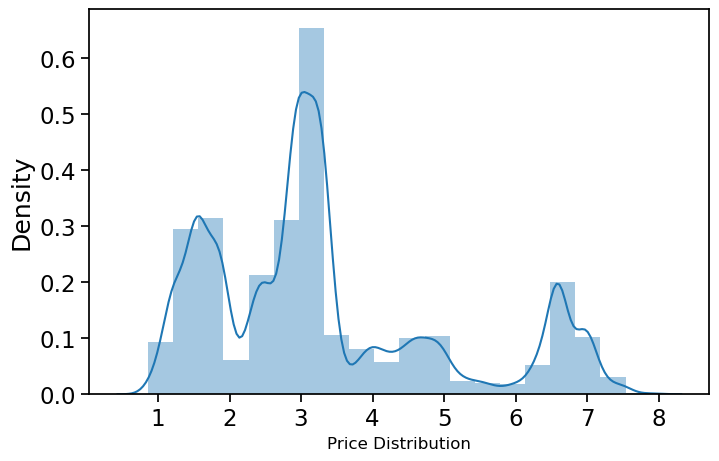

In [79]:
# distribution of Base Price variable
plt.figure(figsize = (8,5))
sns.distplot((train['BASE_PRICE'].values), bins=20, kde=True)
plt.xlabel('Price Distribution', fontsize =12)
plt.show()


- The most of products are priced at $3 and the min and max values are $1 and $8

Feature and Display

In [80]:
train[['FEATURE', 'DISPLAY']].isnull().sum()

FEATURE    0
DISPLAY    0
dtype: int64

In [81]:
train[['FEATURE', 'DISPLAY']].dtypes

FEATURE    int64
DISPLAY    int64
dtype: object

In [82]:
train[['FEATURE', 'DISPLAY']].nunique()

FEATURE    2
DISPLAY    2
dtype: int64

The variables tell about if a product was featured and dispalyed on the day it was sold. Essentially it should a true false values

In [84]:
train['FEATURE'].value_counts(normalize=True)

FEATURE
0    0.900111
1    0.099889
Name: proportion, dtype: float64

In [85]:
# 90% of the products were not featured on the day it was sold

In [88]:
train['FEATURE'].value_counts(normalize=True)

FEATURE
0    0.900111
1    0.099889
Name: proportion, dtype: float64

<Axes: xlabel='FEATURE'>

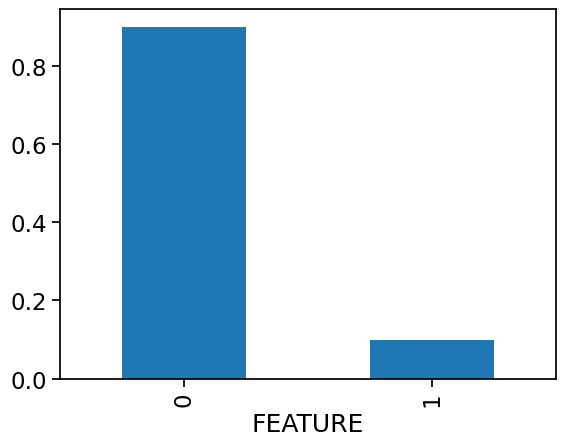

In [89]:
train['FEATURE'].value_counts(normalize=True).plot(kind='bar')

- Approimately 10% of teh product are featured

In [90]:
train['DISPLAY'].value_counts()

DISPLAY
0    200928
1     31359
Name: count, dtype: int64

In [91]:
train['DISPLAY'].value_counts(normalize=True)

DISPLAY
0    0.864999
1    0.135001
Name: proportion, dtype: float64

<Axes: xlabel='DISPLAY'>

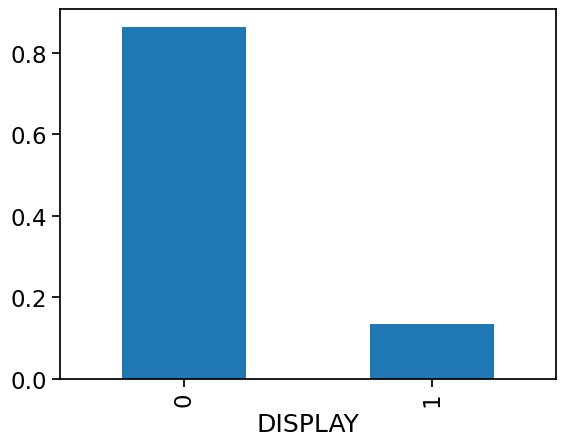

In [92]:
train['DISPLAY'].value_counts(normalize=True).plot(kind='bar')

- 13% of the products are displayed on teh day it was sold

In [99]:
# identifying if the product was featured and dispalyed on the same day it was sold
pd.crosstab(train['FEATURE'], train['DISPLAY']).apply(lambda r :r/len(train))

DISPLAY,0,1
FEATURE,,
0,0.821824,0.078287
1,0.043175,0.056714


82 % the product was not featured or not displayed. Only 5 % of the times the product was featured and dispalyed on the day it was sold

### Distribution of traget variable Units


In [101]:
train['UNITS'].isnull().sum()

0

In [102]:
train['UNITS'].describe()

count    232287.000000
mean         28.063525
std          35.954341
min           0.000000
25%           9.000000
50%          18.000000
75%          34.000000
max        1800.000000
Name: UNITS, dtype: float64

- The range of values is very high
- Minimum number of units sold is 0 and themaximum is 1800
- A huge difference between 75th percentile and the max value indicates presence of outliers

In [103]:
train[train['UNITS']==0].nunique()

WEEK_END_DATE    1
STORE_NUM        1
UPC              1
BASE_PRICE       1
FEATURE          1
DISPLAY          1
UNITS            1
dtype: int64

In [104]:
train[train['UNITS']==0]

,WEEK_END_DATE,STORE_NUM,UPC,BASE_PRICE,FEATURE,DISPLAY,UNITS
76752,2009-12-02,28909,31254742735,4.99,0,0,0


- Only one entry with 0 items sold
- Indicates the given store does not sell that item
- A data anomaly and will not be useful in model training

In [107]:
train = train[train['UNITS']!=0]

In [105]:
train[train['UNITS']==1800]

,WEEK_END_DATE,STORE_NUM,UPC,BASE_PRICE,FEATURE,DISPLAY,UNITS
7960,2009-02-11,25027,1600027527,3.19,1,1,1800


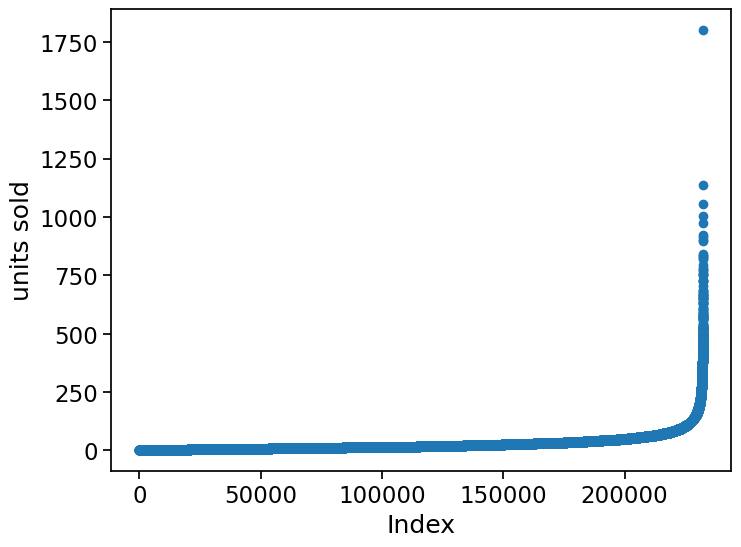

In [111]:
plt.figure(figsize=(8,6))
plt.scatter(x= range(train.shape[0]), y= np.sort(train['UNITS'].values))
plt.xlabel('Index')
plt.ylabel('units sold')
plt.show()

- Most of the values are less than 250
- There are a few outliers with one value way outside the range

In [112]:
train[train['UNITS'] > 1000]

,WEEK_END_DATE,STORE_NUM,UPC,BASE_PRICE,FEATURE,DISPLAY,UNITS
7893,2009-02-11,24991,1600027527,3.19,1,0,1006
7960,2009-02-11,25027,1600027527,3.19,1,1,1800
9597,2009-02-18,25027,1600027527,3.19,0,1,1054
11209,2009-02-25,25027,1600027527,3.19,1,1,1136


- There is only one value with units 1800 and few rows with units more than 1000, we will explore more, when we see the products data

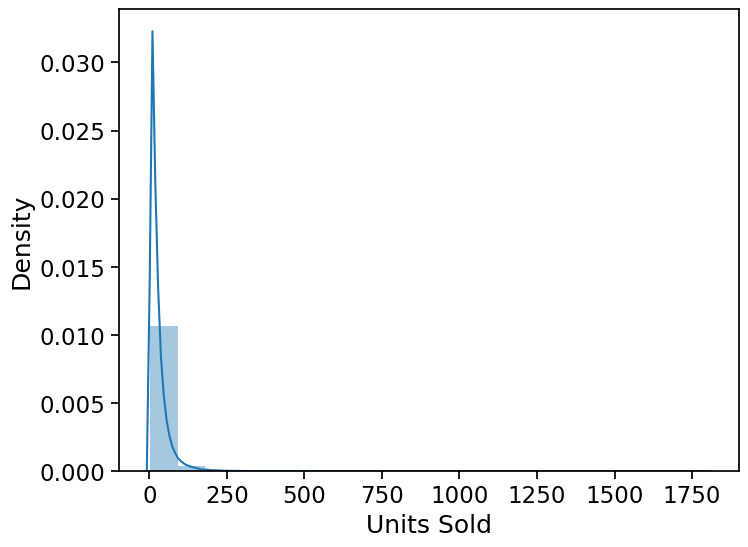

In [114]:
# distribution of units variable
plt.figure(figsize=(8,6))
sns.distplot((train['UNITS'].values), bins=20, kde=True)
plt.xlabel('Units Sold')
plt.show()


The above graph is right skewed and is because of the few values aboue 1000. Hence following a log transformation


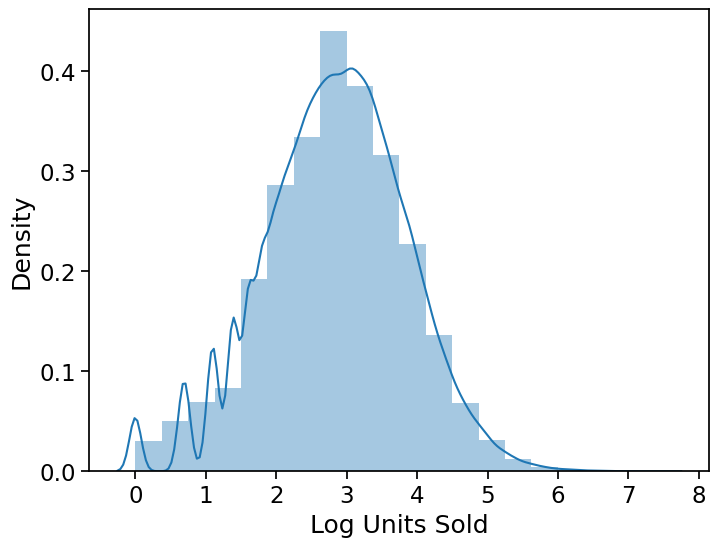

In [118]:
# log transfomed units column
plt.figure(figsize=(8,6))
sns.distplot(np.log(train['UNITS'].values), bins=20, kde=True)
plt.xlabel('Log Units Sold')
plt.show()

The distribution looks close to normal distribution

In [119]:
### Understanding the Product Data

In [139]:
# display firt 5 rows of ata
product_data.head()

,UPC,DESCRIPTION,MANUFACTURER,CATEGORY,SUB_CATEGORY,PRODUCT_SIZE
0,1111009477,PL MINI TWIST PRETZELS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
1,1111009497,PL PRETZEL STICKS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
2,1111009507,PL TWIST PRETZELS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
3,1111038078,PL BL MINT ANTSPTC RINSE,PRIVATE LABEL,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),500 ML
4,1111038080,PL ANTSPTC SPG MNT MTHWS,PRIVATE LABEL,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC),500 ML


In [121]:
product_data.dtypes

UPC              int64
DESCRIPTION     object
MANUFACTURER    object
CATEGORY        object
SUB_CATEGORY    object
PRODUCT_SIZE    object
dtype: object

**Categorical variables**
- Check the unique values for categorical variables
- Are there any missing values in the variables?
- Is there any variable with high cardinality/ sparsity?


- Checking for null values in all the columns

In [122]:
product_data.isnull().sum()

UPC             0
DESCRIPTION     0
MANUFACTURER    0
CATEGORY        0
SUB_CATEGORY    0
PRODUCT_SIZE    0
dtype: int64

- None of the columns have null values in the data

UPC

In [123]:
product_data['UPC'].nunique()

30

This unique product code number is consistent with the train data

### Are the product codes exactly the same as in train data ?


In [144]:
len(set(product_data.UPC).intersection(set(train.UPC)))

30

There are 30 common product codes which means there is a 1 to 1 match in the UPC across the two datasets

CATEGORY

In [147]:
# number and list of unique categories in the product data
product_data['CATEGORY'].nunique(), list(product_data['CATEGORY'].unique())

(4, ['BAG SNACKS', 'ORAL HYGIENE PRODUCTS', 'COLD CEREAL', 'FROZEN PIZZA'])

In [148]:
product_data['CATEGORY'].isnull().sum()

0

In [149]:
product_data['CATEGORY'].value_counts().sort_values()

CATEGORY
ORAL HYGIENE PRODUCTS    6
FROZEN PIZZA             7
BAG SNACKS               8
COLD CEREAL              9
Name: count, dtype: int64

We have 4 product categories and 9 product ids are labelled as cold cereal, 8 are Bag snacks, 7 are Frozen pizza nad 6 are oral hygiene products

Lets look at the sub category feature to learn more

In [150]:
product_data['SUB_CATEGORY'].nunique(), list(product_data['SUB_CATEGORY'].unique())

(7,
 ['PRETZELS',
  'MOUTHWASHES (ANTISEPTIC)',
  'ALL FAMILY CEREAL',
  'ADULT CEREAL',
  'PIZZA/PREMIUM',
  'MOUTHWASH/RINSES AND SPRAYS',
  'KIDS CEREAL'])

There are 7 unique sub categories in the prodcut data

In [152]:
product_data['SUB_CATEGORY'].value_counts().sort_values()

SUB_CATEGORY
ADULT CEREAL                   1
MOUTHWASH/RINSES AND SPRAYS    1
KIDS CEREAL                    2
MOUTHWASHES (ANTISEPTIC)       5
ALL FAMILY CEREAL              6
PIZZA/PREMIUM                  7
PRETZELS                       8
Name: count, dtype: int64

In [153]:
product_data[product_data['SUB_CATEGORY']=='PRETZELS']

,UPC,DESCRIPTION,MANUFACTURER,CATEGORY,SUB_CATEGORY,PRODUCT_SIZE
0,1111009477,PL MINI TWIST PRETZELS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
1,1111009497,PL PRETZEL STICKS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
2,1111009507,PL TWIST PRETZELS,PRIVATE LABEL,BAG SNACKS,PRETZELS,15 OZ
14,2840004768,RLDGLD TINY TWISTS PRTZL,FRITO LAY,BAG SNACKS,PRETZELS,16 OZ
15,2840004770,RLDGLD PRETZEL STICKS,FRITO LAY,BAG SNACKS,PRETZELS,16 OZ
25,7797502248,SNYDR PRETZEL RODS,SNYDER S,BAG SNACKS,PRETZELS,10 OZ
26,7797508004,SNYDR SOURDOUGH NIBBLERS,SNYDER S,BAG SNACKS,PRETZELS,16 OZ
27,7797508006,SNYDR FF MINI PRETZELS,SNYDER S,BAG SNACKS,PRETZELS,16 OZ


In [156]:
# displaying the sub categories against each category
product_data[['CATEGORY', 'SUB_CATEGORY']].drop_duplicates().sort_values(by='CATEGORY')

,CATEGORY,SUB_CATEGORY
0,BAG SNACKS,PRETZELS
5,COLD CEREAL,ALL FAMILY CEREAL
6,COLD CEREAL,ADULT CEREAL
19,COLD CEREAL,KIDS CEREAL
8,FROZEN PIZZA,PIZZA/PREMIUM
3,ORAL HYGIENE PRODUCTS,MOUTHWASHES (ANTISEPTIC)
16,ORAL HYGIENE PRODUCTS,MOUTHWASH/RINSES AND SPRAYS


The sub-categories give additional detail about the product.

- Cereal has 3 sub categoires,differentaiting on the age group
- Oral hygiene has 2 sub categories, antiseptic and rinse/spray
- Bag Snacks and Frozen Pizza have only one sub catgeory each, no further division

Does the sub category has anything to do with the size of the product?


Product size


In [157]:
product_data[['CATEGORY', 'SUB_CATEGORY','PRODUCT_SIZE']].drop_duplicates().sort_values(by='CATEGORY')

,CATEGORY,SUB_CATEGORY,PRODUCT_SIZE
0,BAG SNACKS,PRETZELS,15 OZ
14,BAG SNACKS,PRETZELS,16 OZ
25,BAG SNACKS,PRETZELS,10 OZ
6,COLD CEREAL,ADULT CEREAL,20 OZ
7,COLD CEREAL,ALL FAMILY CEREAL,18 OZ
19,COLD CEREAL,KIDS CEREAL,15 OZ
20,COLD CEREAL,KIDS CEREAL,12.2 OZ
5,COLD CEREAL,ALL FAMILY CEREAL,12.25 OZ
13,COLD CEREAL,ALL FAMILY CEREAL,12 OZ
8,FROZEN PIZZA,PIZZA/PREMIUM,32.7 OZ


The cold cereal for kids is available in two different sizes. Also, the cold cereal for all family has the same size as the cold cereal for kids. Hence subcategory is not an indicator of size



###### **Summary:**


- Bag of Snacks has 1 sub category and 3 product sizes
- Oral hygiene has 2 sub categories and 2 sizes
- Frozen Pizza has 1 sub category and 6 sizes available
- COld cereals has 3 sub categories and 6 different sizes

## DESCRIPTION

In [158]:
product_data['DESCRIPTION'].nunique(), list(product_data['DESCRIPTION'].unique())

(29,
 ['PL MINI TWIST PRETZELS',
  'PL PRETZEL STICKS',
  'PL TWIST PRETZELS',
  'PL BL MINT ANTSPTC RINSE',
  'PL ANTSPTC SPG MNT MTHWS',
  'PL HONEY NUT TOASTD OATS',
  'PL RAISIN BRAN',
  'PL BT SZ FRSTD SHRD WHT',
  'PL SR CRUST SUPRM PIZZA',
  'PL SR CRUST 3 MEAT PIZZA',
  'PL SR CRUST PEPPRN PIZZA',
  'GM HONEY NUT CHEERIOS',
  'GM CHEERIOS',
  'RLDGLD TINY TWISTS PRTZL',
  'RLDGLD PRETZEL STICKS',
  'SCOPE ORIG MINT MOUTHWASH',
  'CREST PH CLN MINT RINSE',
  'KELL BITE SIZE MINI WHEAT',
  'KELL FROSTED FLAKES',
  'KELL FROOT LOOPS',
  'DIGIORNO THREE MEAT',
  'DIGRN SUPREME PIZZA',
  'DIGRN PEPP PIZZA',
  'FRSC BRCK OVN ITL PEP PZ',
  'SNYDR PRETZEL RODS',
  'SNYDR SOURDOUGH NIBBLERS',
  'SNYDR FF MINI PRETZELS',
  'LSTRNE CL MINT ANTSPTC MW',
  'LSTRNE FRS BRST ANTSPC MW'])

- We have 29 product descriptions, but 30 products. So all product ids have a unique description but 1 description has been repeated

In [159]:
product_data['DESCRIPTION'].value_counts()

DESCRIPTION
GM CHEERIOS                  2
PL MINI TWIST PRETZELS       1
SCOPE ORIG MINT MOUTHWASH    1
LSTRNE CL MINT ANTSPTC MW    1
SNYDR FF MINI PRETZELS       1
SNYDR SOURDOUGH NIBBLERS     1
SNYDR PRETZEL RODS           1
FRSC BRCK OVN ITL PEP PZ     1
DIGRN PEPP PIZZA             1
DIGRN SUPREME PIZZA          1
DIGIORNO THREE MEAT          1
KELL FROOT LOOPS             1
KELL FROSTED FLAKES          1
KELL BITE SIZE MINI WHEAT    1
CREST PH CLN MINT RINSE      1
RLDGLD PRETZEL STICKS        1
PL PRETZEL STICKS            1
RLDGLD TINY TWISTS PRTZL     1
GM HONEY NUT CHEERIOS        1
PL SR CRUST PEPPRN PIZZA     1
PL SR CRUST 3 MEAT PIZZA     1
PL SR CRUST SUPRM PIZZA      1
PL BT SZ FRSTD SHRD WHT      1
PL RAISIN BRAN               1
PL HONEY NUT TOASTD OATS     1
PL ANTSPTC SPG MNT MTHWS     1
PL BL MINT ANTSPTC RINSE     1
PL TWIST PRETZELS            1
LSTRNE FRS BRST ANTSPC MW    1
Name: count, dtype: int64

In [160]:
product_data[product_data['DESCRIPTION']=='GM CHEERIOS']

,UPC,DESCRIPTION,MANUFACTURER,CATEGORY,SUB_CATEGORY,PRODUCT_SIZE
12,1600027528,GM CHEERIOS,GENERAL MI,COLD CEREAL,ALL FAMILY CEREAL,18 OZ
13,1600027564,GM CHEERIOS,GENERAL MI,COLD CEREAL,ALL FAMILY CEREAL,12 OZ


There are 2 UPC for the same description, manufacturer, category and sub category. The only difference is that the product is availabel in 2 different sizes

In [164]:
# In train data we saw that one product has extremley high sales value, checking that product 
train[train['UNITS']==1800]['UPC']

7960    1600027527
Name: UPC, dtype: int64

In [165]:
product_data[product_data['UPC']==1600027527]

,UPC,DESCRIPTION,MANUFACTURER,CATEGORY,SUB_CATEGORY,PRODUCT_SIZE
11,1600027527,GM HONEY NUT CHEERIOS,GENERAL MI,COLD CEREAL,ALL FAMILY CEREAL,12.25 OZ


- may be the manufacturer or the brnading is the reason for sucha high sales, we will come back to this

MANUFACTURER

- How many manufacturers/suppliers are we associated with?

- Are same products created by multiple manufacturers?

In [167]:
product_data['MANUFACTURER'].nunique(), list(product_data['MANUFACTURER'].unique())

(9,
 ['PRIVATE LABEL',
  'GENERAL MI',
  'FRITO LAY',
  'P & G',
  'KELLOGG',
  'TOMBSTONE',
  'TONYS',
  'SNYDER S',
  'WARNER'])

There are 9 manufacturers

In [168]:
# displaying the list of manufacturers against 4 categories
temp = product_data[['CATEGORY','MANUFACTURER']].drop_duplicates()

In [169]:
pd.crosstab(temp['CATEGORY'], temp['MANUFACTURER'])

MANUFACTURER,FRITO LAY,GENERAL MI,KELLOGG,P & G,PRIVATE LABEL,SNYDER S,TOMBSTONE,TONYS,WARNER
CATEGORY,,,,,,,,,
BAG SNACKS,1,0,0,0,1,1,0,0,0
COLD CEREAL,0,1,1,0,1,0,0,0,0
FROZEN PIZZA,0,0,0,0,1,0,1,1,0
ORAL HYGIENE PRODUCTS,0,0,0,1,1,0,0,0,1


- We have 4 unique categories of Products
- Each category has 3 manufacturers
- Every category has a manufcaturer 'Private Label' and 2 other manufacturers

## Understanding the Store Data

In [171]:
#looking at first 5 records
store_data.head()

,STORE_ID,STORE_NAME,ADDRESS_CITY_NAME,ADDRESS_STATE_PROV_CODE,MSA_CODE,SEG_VALUE_NAME,PARKING_SPACE_QTY,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS
0,367,15TH & MADISON,COVINGTON,KY,17140,VALUE,196.0,24721,12707
1,389,SILVERLAKE,ERLANGER,KY,17140,MAINSTREAM,408.0,46073,24767
2,613,EAST ALLEN,ALLEN,TX,19100,MAINSTREAM,464.0,64926,29386
3,623,HOUSTON,HOUSTON,TX,26420,MAINSTREAM,NaN,46930,36741
4,2277,ANDERSON TOWNE CTR,CINCINNATI,OH,17140,UPSCALE,NaN,81958,54053


In [172]:
store_data.columns

Index(['STORE_ID', 'STORE_NAME', 'ADDRESS_CITY_NAME',
       'ADDRESS_STATE_PROV_CODE', 'MSA_CODE', 'SEG_VALUE_NAME',
       'PARKING_SPACE_QTY', 'SALES_AREA_SIZE_NUM', 'AVG_WEEKLY_BASKETS'],
      dtype='object')

In [173]:
store_data.dtypes


STORE_ID                     int64
STORE_NAME                  object
ADDRESS_CITY_NAME           object
ADDRESS_STATE_PROV_CODE     object
MSA_CODE                     int64
SEG_VALUE_NAME              object
PARKING_SPACE_QTY          float64
SALES_AREA_SIZE_NUM          int64
AVG_WEEKLY_BASKETS           int64
dtype: object

**Numerical Variables**
- Check the distribution of the numerical variables
- Are there any extreme values?
- Are there any missingvalues in teh variables?


**Categorical Varibales**
- Check the unique values for the categorical variables
- Are there any missing values in the variables?
- Is there any variable with high cardinality/sparsity?


### STORE_ID

In [174]:
store_data['STORE_ID'].nunique()

76

In [176]:
len(set(store_data.STORE_ID).intersection(set(train.STORE_NUM)))

76

STORE_NUM

In [177]:
store_data['STORE_NAME'].isnull().sum()

0

In [180]:
store_data['STORE_NAME'].nunique()

72

So there are 76 stores but 72 store names. Lets find which store names are repeated

In [179]:
store_data['STORE_NAME'].value_counts()

STORE_NAME
HOUSTON            4
MIDDLETOWN         2
15TH & MADISON     1
DUNCANVILLE        1
WOOD FOREST S/C    1
                  ..
AT EASTEX FRWY     1
DENT               1
THE WOODLANDS      1
LANDEN             1
CARROLLTON         1
Name: count, Length: 72, dtype: int64

Houston and middletown are repeated 

In [181]:
store_data[store_data['STORE_NAME']=='HOUSTON']

,STORE_ID,STORE_NAME,ADDRESS_CITY_NAME,ADDRESS_STATE_PROV_CODE,MSA_CODE,SEG_VALUE_NAME,PARKING_SPACE_QTY,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS
3,623,HOUSTON,HOUSTON,TX,26420,MAINSTREAM,NaN,46930,36741
9,2513,HOUSTON,HOUSTON,TX,26420,UPSCALE,NaN,61833,32423
54,21485,HOUSTON,KATY,TX,26420,MAINSTREAM,NaN,46369,26472
59,23327,HOUSTON,HOUSTON,TX,26420,MAINSTREAM,NaN,50722,30258


In [182]:
store_data[store_data['STORE_NAME']=='MIDDLETOWN']

,STORE_ID,STORE_NAME,ADDRESS_CITY_NAME,ADDRESS_STATE_PROV_CODE,MSA_CODE,SEG_VALUE_NAME,PARKING_SPACE_QTY,SALES_AREA_SIZE_NUM,AVG_WEEKLY_BASKETS
50,21221,MIDDLETOWN,MIDDLETOWN,OH,17140,VALUE,NaN,48128,17010
74,28909,MIDDLETOWN,MIDDLETOWN,OH,17140,MAINSTREAM,NaN,85876,28986


The store names which are repeated are actually different stores which either have a different city or different segment (upscale, mainstream, value) or location. Hence they have different store ids


In [185]:
store_data[['ADDRESS_STATE_PROV_CODE','ADDRESS_CITY_NAME']].isnull().sum()

ADDRESS_STATE_PROV_CODE    0
ADDRESS_CITY_NAME          0
dtype: int64

In [187]:
store_data[['ADDRESS_STATE_PROV_CODE','ADDRESS_CITY_NAME']].nunique()

ADDRESS_STATE_PROV_CODE     4
ADDRESS_CITY_NAME          51
dtype: int64

There are 4 states and a total of 51 cities

In [188]:
store_data.groupby(['ADDRESS_STATE_PROV_CODE'])['STORE_ID'].count()

ADDRESS_STATE_PROV_CODE
IN     1
KY     4
OH    30
TX    41
Name: STORE_ID, dtype: int64

- Each store has a unique store id
- Most stores are from Ohio and Texas - 93%
- Few from Kentucky and Indiana 7%

In [189]:
store_data.groupby(['ADDRESS_STATE_PROV_CODE'])['ADDRESS_CITY_NAME'].nunique()

ADDRESS_STATE_PROV_CODE
IN     1
KY     3
OH    16
TX    31
Name: ADDRESS_CITY_NAME, dtype: int64

- There are 41 stores in Texas located in 31 cities
- There are 30 stores in Ohio located in 16 cities
- 4 stores in Kentucky located in 3 cities
- 1 store in Indiana in 1 city

In [190]:
store_data['ADDRESS_CITY_NAME'].value_counts()

ADDRESS_CITY_NAME
CINCINNATI         9
HOUSTON            8
MIDDLETOWN         3
COVINGTON          2
SUGAR LAND         2
LOVELAND           2
MAINEVILLE         2
HAMILTON           2
KATY               2
MCKINNEY           2
DAYTON             2
CROWLEY            1
GOSHEN             1
PASADENA           1
WOODLANDS          1
MESQUITE           1
SPRINGFIELD        1
FLOWER MOUND       1
SOUTHLAKE          1
FRISCO             1
WEST CHESTER       1
DENTON             1
CYPRESS            1
LEBANON            1
RICHARDSON         1
GARLAND            1
KETTERING          1
DUNCANVILLE        1
VANDALIA           1
MAGNOLIA           1
BEAUMONT           1
ALLEN              1
MILFORD            1
BLUE ASH           1
CLUTE              1
DICKINSON          1
GRAND PRAIRIE      1
ARLINGTON          1
LAWRENCEBURG       1
ROCKWALL           1
COLLEGE STATION    1
MASON              1
SAINT MARYS        1
KINGWOOD           1
BAYTOWN            1
THE WOODLANDS      1
INDEPENDENCE    

In [191]:
# CINCINNATI , HOUSTON, MIDDLETOWN have 9, 8 and  3 stores respectivelu. All the other cities have 2 or 1 stores


This variable has a very high cardinality, since we have 51 cities within 4 states

MSA_CODE

In [192]:
store_data['MSA_CODE'].isnull().sum()

0

In [194]:
store_data['MSA_CODE'].nunique(), store_data['MSA_CODE'].unique()

(9, array([17140, 19100, 26420, 17780, 47540, 43300, 19380, 13140, 44220]))

In [195]:
store_data['MSA_CODE'].value_counts()

MSA_CODE
17140    29
26420    21
19100    17
19380     4
17780     1
47540     1
43300     1
13140     1
44220     1
Name: count, dtype: int64

17140 is a popular code

In [196]:
store_data.groupby(['MSA_CODE','ADDRESS_STATE_PROV_CODE'])['STORE_ID'].count()

MSA_CODE  ADDRESS_STATE_PROV_CODE
13140     TX                          1
17140     IN                          1
          KY                          4
          OH                         24
17780     TX                          1
19100     TX                         17
19380     OH                          4
26420     TX                         21
43300     TX                          1
44220     OH                          1
47540     OH                          1
Name: STORE_ID, dtype: int64

- These codes are assigned based on geographical location and population density
- 17140 code is present in all 3 except Texas and it falls in different geographical region

In [198]:
store_data.columns

Index(['STORE_ID', 'STORE_NAME', 'ADDRESS_CITY_NAME',
       'ADDRESS_STATE_PROV_CODE', 'MSA_CODE', 'SEG_VALUE_NAME',
       'PARKING_SPACE_QTY', 'SALES_AREA_SIZE_NUM', 'AVG_WEEKLY_BASKETS'],
      dtype='object')

PARKING_SPACE_QTY and SALES_AREA_SIZE_NUM

In [200]:
store_data[['PARKING_SPACE_QTY', 'SALES_AREA_SIZE_NUM']].isnull().sum()

PARKING_SPACE_QTY      51
SALES_AREA_SIZE_NUM     0
dtype: int64

Out of 76 stores, 51 stores have no data for parking

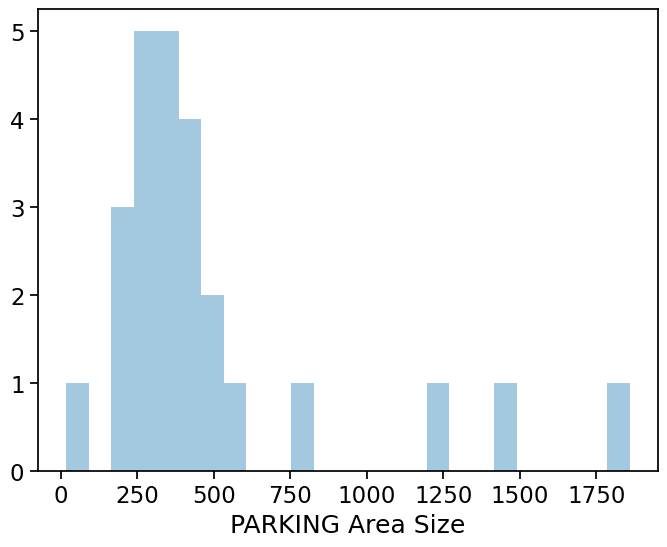

In [208]:
plt.figure(figsize=(8,6))
sns.distplot(store_data['PARKING_SPACE_QTY'], bins=25,kde=False)
plt.xlabel('PARKING Area Size')
plt.show()

- Most of stores do not have parking space
- Stores which have parking space have 250- 500 units of parking area
- Very few stores have > 750 parking units

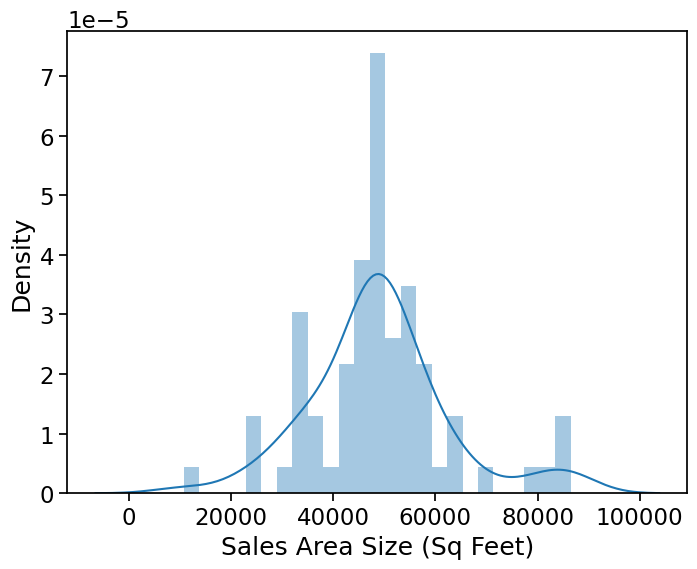

In [210]:
plt.figure(figsize=(8,6))
sns.distplot(store_data['SALES_AREA_SIZE_NUM'], bins=25,kde=True)
plt.xlabel('Sales Area Size (Sq Feet)')
plt.show()

- Most of the stores have area between 30000 to 70000 sq feet
- Very few stores have area less than 30K or above 80K

In [212]:
store_data.groupby(['ADDRESS_STATE_PROV_CODE'])['SALES_AREA_SIZE_NUM'].mean().sort_values(ascending=False)

ADDRESS_STATE_PROV_CODE
IN    58563.000000
OH    52691.200000
TX    46920.902439
KY    39855.500000
Name: SALES_AREA_SIZE_NUM, dtype: float64

IN has only 1 store and the area is 58K
OH and TX have an avg store size of 52k and 46K, while KY has an avg store area of 40K

In [214]:
state_oh = store_data[store_data['ADDRESS_STATE_PROV_CODE']=='OH']
state_tx = store_data[store_data['ADDRESS_STATE_PROV_CODE']=='TX']

<Axes: xlabel='SALES_AREA_SIZE_NUM', ylabel='Density'>

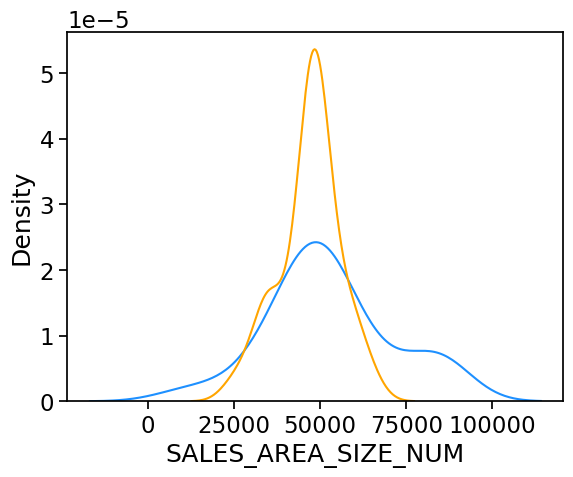

In [215]:
sns.distplot(state_oh['SALES_AREA_SIZE_NUM'], hist=False, color='dodgerblue', label='OHIO')
sns.distplot(state_tx['SALES_AREA_SIZE_NUM'], hist=False, color='orange',label='Texas')

- Indiana has only one store and the area is 58K
- Ohio and Texas have avg around 52k and 50K
- Ohio has stores distributed at all sizes
- Texas has stores between 30K to 60K sq ft of area

AVG_WEEKLY_BASKETS

In [216]:
store_data['AVG_WEEKLY_BASKETS'].isnull().sum()

0

In [217]:
store_data['AVG_WEEKLY_BASKETS'].describe()

count       76.000000
mean     24226.921053
std       8863.939362
min      10435.000000
25%      16983.500000
50%      24667.500000
75%      29398.500000
max      54053.000000
Name: AVG_WEEKLY_BASKETS, dtype: float64

The minimum baskets sold are ~10K and the max goes arnd 54K


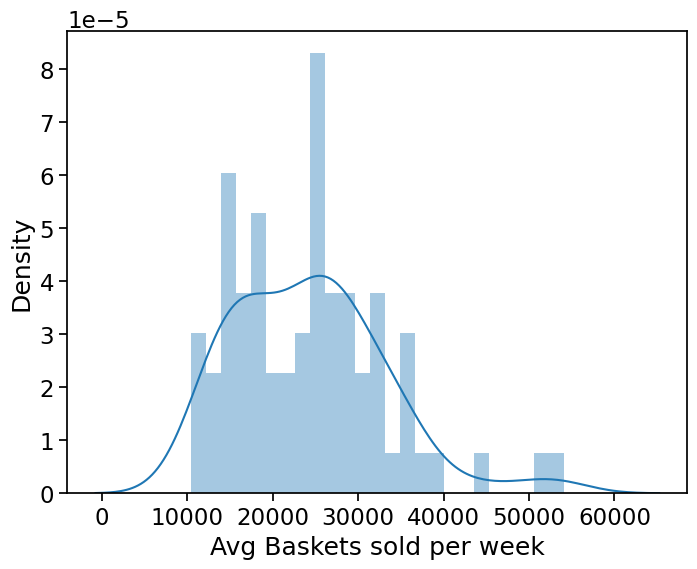

In [219]:
plt.figure(figsize=(8,6))
sns.distplot(store_data['AVG_WEEKLY_BASKETS'], kde=True, bins=25)
plt.xlabel('Avg Baskets sold per week')
plt.show()

What are the avg baskets sold for different states

In [220]:
store_data.groupby(['ADDRESS_STATE_PROV_CODE'])['AVG_WEEKLY_BASKETS'].mean().sort_values(ascending=False)

ADDRESS_STATE_PROV_CODE
OH    26113.766667
TX    23234.195122
KY    21489.000000
IN    19275.000000
Name: AVG_WEEKLY_BASKETS, dtype: float64

OH has avg of 26K 
TX has avg of 23K
KY has avg of 21K
IN has one store with avg of 19k

SEG_VALUE_NAME

The feature depends on the neighbourhood and the quality of the products

In [223]:
store_data['SEG_VALUE_NAME'].isnull().sum()

0

There are certain segments assigned to store, based on the brand and quality of the products sold at the store.

- Upscale stores: Located in high income neighbourhoods and offer more high end product
- Mainstream stores: Located in middle class areas, offering a mix of upscale and value product
- Value stores: Focus on low prices products targetiing low income customers

Lets look at the distribution of stores in each of the segment

In [224]:
store_data['SEG_VALUE_NAME'].value_counts()

SEG_VALUE_NAME
MAINSTREAM    43
VALUE         19
UPSCALE       14
Name: count, dtype: int64

In [225]:
store_data.columns

Index(['STORE_ID', 'STORE_NAME', 'ADDRESS_CITY_NAME',
       'ADDRESS_STATE_PROV_CODE', 'MSA_CODE', 'SEG_VALUE_NAME',
       'PARKING_SPACE_QTY', 'SALES_AREA_SIZE_NUM', 'AVG_WEEKLY_BASKETS'],
      dtype='object')

Does the segment has any relation with store area?

Is there a difference in the avergae ales fro each segmnet?

In [226]:
store_data.groupby(['SEG_VALUE_NAME'])['SALES_AREA_SIZE_NUM'].mean().sort_values(ascending=False)

SEG_VALUE_NAME
UPSCALE       59556.428571
MAINSTREAM    50075.976744
VALUE         38706.368421
Name: SALES_AREA_SIZE_NUM, dtype: float64

upscale stores have hugh area while the value has less area

In [227]:
store_data.groupby(['SEG_VALUE_NAME'])['AVG_WEEKLY_BASKETS'].mean().sort_values(ascending=False)

SEG_VALUE_NAME
UPSCALE       28735.928571
MAINSTREAM    24024.093023
VALUE         21363.526316
Name: AVG_WEEKLY_BASKETS, dtype: float64

Not so much difference here but still upsclae has higher baskets sold, whereas value has lower baskets sold